# Setup
Import all libraries and functions needed.

In [1]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
import math
import pydicom
import ipywidgets as widgets
import os
from IPython.display import display


from material import *
from source import *
from attenuate import *
from ct_detect import *
from fake_source import *
from ct_phantom import *
from ct_lib import *
from ct_scan import *
from ct_calibrate import *
from back_project import *
from scan_and_reconstruct import *
from create_dicom import *
from xtreme import *
from ct_interface import *
from ct_test_example import *

Initialize Material and Source object which store relevant data.

In [2]:
material = Material()
source = Source()

In [3]:
test_1(1)

Scanning angle: 256   
Ramp filtering
Reconstructing angle: 256   


# 3.3 Experiments

Examine linear attenuation coefficients over energies (for water).

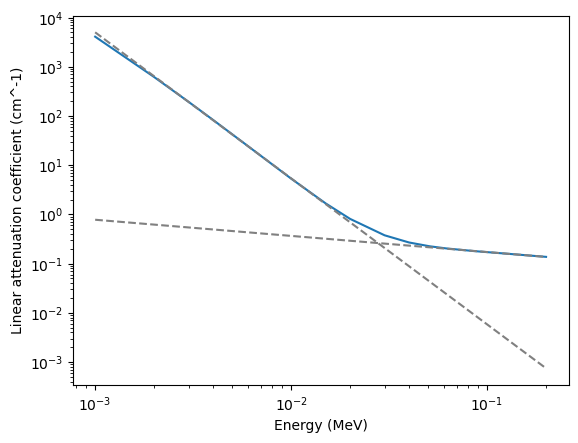

Transition Region about energies: [0.02, 0.06]


In [4]:
from scipy.optimize import curve_fit

energies = material.mev
coeff_w = material.coeff('Water')


# Plot asymptotic behavior
x1, y1 = energies[5:20], coeff_w[5:20]
x2, y2 = energies[60:], coeff_w[60:]

def power_law(x, a, b):
    return a * x**b

popt1,_= curve_fit(power_law, x1, y1)
a1, b1 = popt1
popt2,_= scipy.optimize.curve_fit(power_law, x2, y2)
a2, b2 = popt2

y1_fit = power_law(energies, a1, b1)
y2_fit = power_law(energies, a2, b2)

plt.figure()
plt.loglog(energies, coeff_w, label='Water')
plt.loglog(energies, y1_fit, linestyle='--', color='grey')
plt.loglog(energies, y2_fit, linestyle='--', color='grey')
plt.xlabel('Energy (MeV)')
plt.ylabel('Linear attenuation coefficient (cm^-1)')
plt.show()

print(f"Transition Region about energies: {[energies[19], energies[59]]}")

Use ct_detect to investigate attentuation of a material (water) with different depths. <br>
Compare different source photon types, all with peak energy at 100kVp and filtered by 2mmAl.

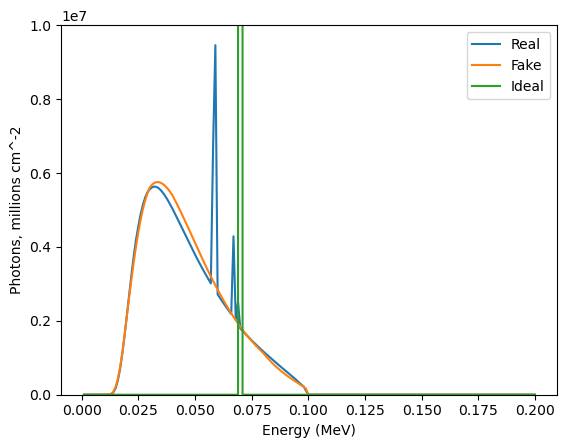

In [5]:
s_real = source.photon('100kVp, 2mm Al')
s_fake = fake_source(energies, 0.1, material.coeff('Aluminium'), 2)
s_ideal = fake_source(energies, 0.1, material.coeff('Aluminium'), 2, 'ideal')

plt.figure()
plt.plot(energies, s_real, label='Real')
plt.plot(energies, s_fake, label='Fake')
plt.plot(energies, s_ideal, label='Ideal')
plt.xlabel('Energy (MeV)')
plt.ylabel('Photons, millions cm^-2')
plt.ylim(0,10**7)
plt.legend()
plt.show()


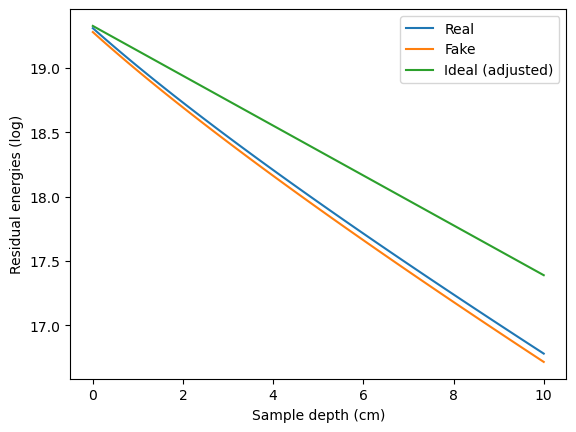

Ideal source residual energies are adjusted to match real source residual energies


In [6]:
depth_ary = np.arange(0, 10.1, 0.1)
y_real = ct_detect(s_real, material.coeff('Water'), depth_ary, 1) # FIXME: set all mas to 1 for now
y_fake = ct_detect(s_fake, material.coeff('Water'), depth_ary, 1)
y_ideal = ct_detect(s_ideal, material.coeff('Water'), depth_ary, 1)

plt.figure()
plt.plot(depth_ary, np.log(y_real), label='Real')
plt.plot(depth_ary, np.log(y_fake), label='Fake')
plt.plot(depth_ary, np.log(y_ideal)-3.7, label='Ideal (adjusted)')
plt.xlabel('Sample depth (cm)')
plt.ylabel('Residual energies (log)')
plt.legend()
plt.show()

print("Ideal source residual energies are adjusted to match real source residual energies")

Compare different materials.

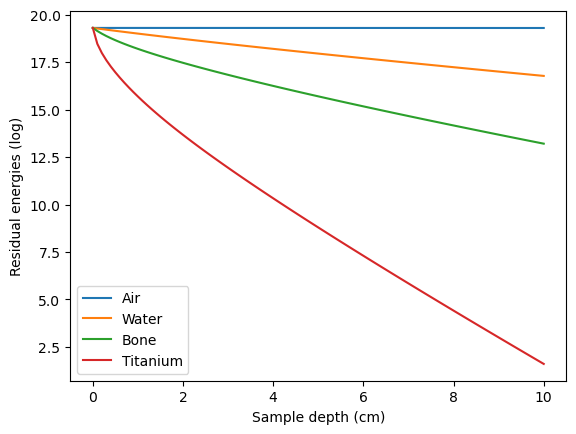

In [7]:
# Using a real source
s_real = source.photon('100kVp, 2mm Al')
y_air = ct_detect(s_real, material.coeff('Air'), depth_ary, 1)
y_water = ct_detect(s_real, material.coeff('Water'), depth_ary, 1)
y_bone = ct_detect(s_real, material.coeff('Bone'), depth_ary, 1)
y_ti = ct_detect(s_real, material.coeff('Titanium'), depth_ary, 1)

plt.figure()
plt.plot(depth_ary, np.log(y_air), label='Air')
plt.plot(depth_ary, np.log(y_water), label='Water')
plt.plot(depth_ary, np.log(y_bone), label='Bone')
plt.plot(depth_ary, np.log(y_ti), label='Titanium')
plt.legend()
plt.xlabel('Sample depth (cm)')
plt.ylabel('Residual energies (log)')
plt.show()

# 4.3 Experiments

#### Investigate sinograms of different phantom shapes
Construct a sinogram (residual energies) using ct_scan function for:
- 2. impulse at origin
- 2. impulse with offset
- 1. disk
- 3. hip implant

In [8]:
s_ideal = fake_source(energies, 0.1, material.coeff('Aluminium'), 2, 'ideal')
scale = 0.1 # 0.1 cm per pixel
angles = 256

In [9]:
p2_origin = ct_phantom(material.name, 256, 2, 'Titanium')
p2_offset = ct_phantom(material.name, 256, 2, 'Titanium', [20,20])
y2_origin = ct_scan(s_ideal, material, p2_origin, scale, angles)
y2_offset = ct_scan(s_ideal, material, p2_offset, scale, angles)

Scanning angle: 256   
Scanning angle: 256   


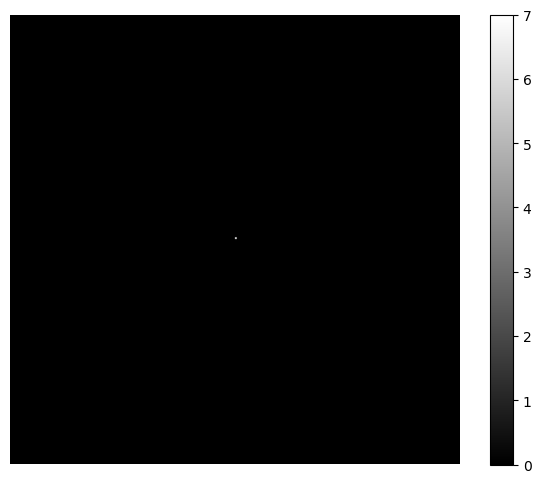

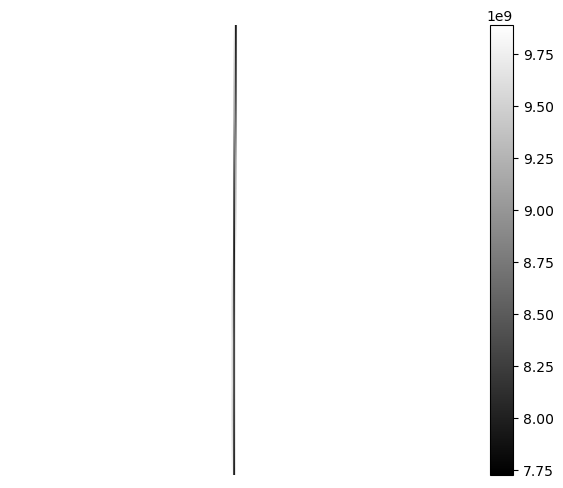

In [10]:
draw(p2_origin)
draw(y2_origin)

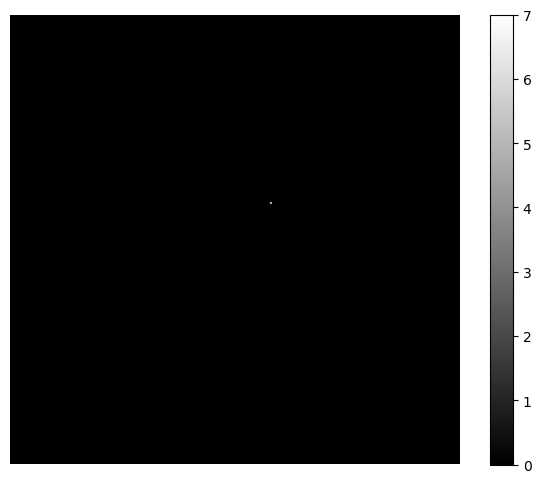

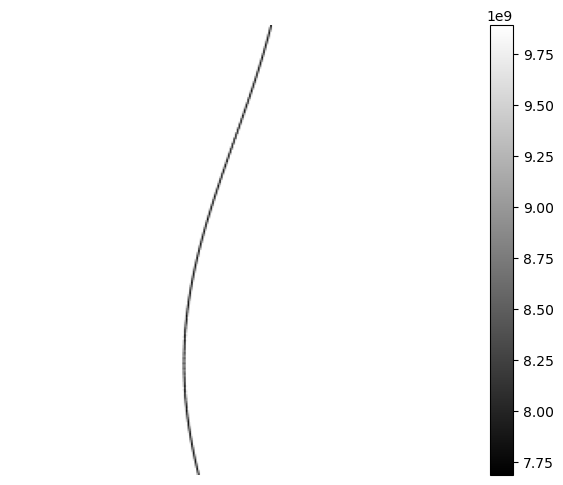

In [11]:
draw(p2_offset)
draw(y2_offset)

In [12]:
p1 = ct_phantom(material.name, 256, 1, 'Water')
y1 = ct_scan(s_ideal, material, p1, scale, angles)

Scanning angle: 256   


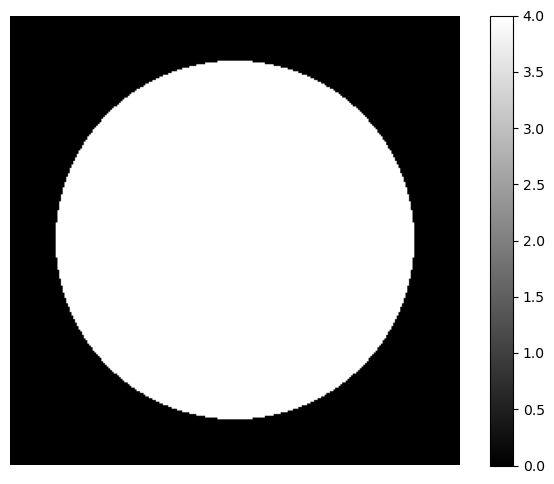

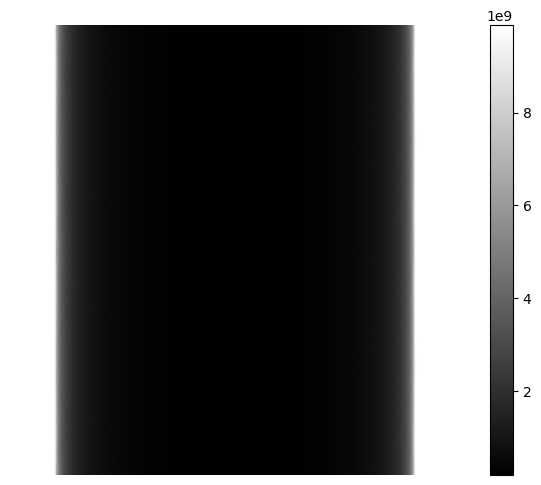

In [13]:
draw(p1)
draw(y1)

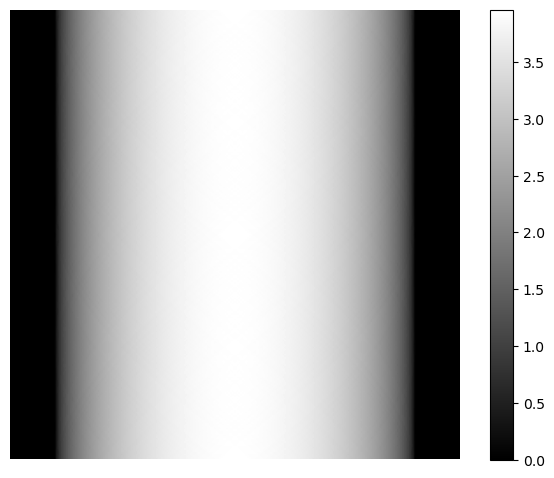

In [14]:
y1_calibrate = ct_calibrate(s_ideal, material, y1, scale)
draw(y1_calibrate)

In [15]:
p3 = ct_phantom(material.name, 256, 3, 'Titanium')
y3 = ct_scan(s_ideal, material, p3, scale, angles)

Scanning angle: 256   


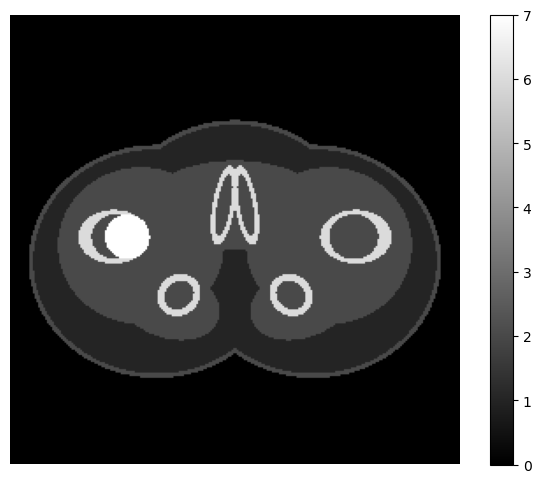

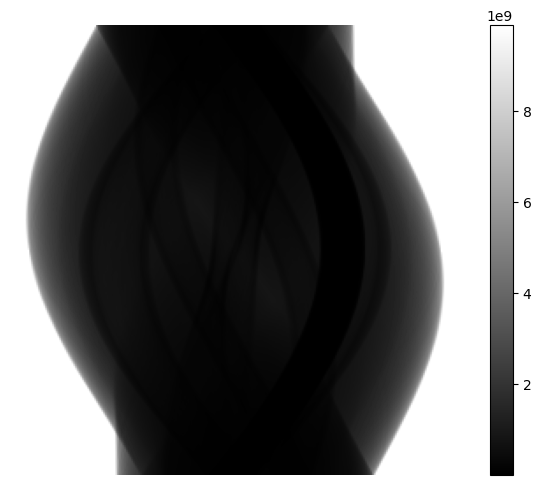

In [16]:
draw(p3)
draw(y3)

#### Investigate effect of number of angles.

Scanning angle: 64   


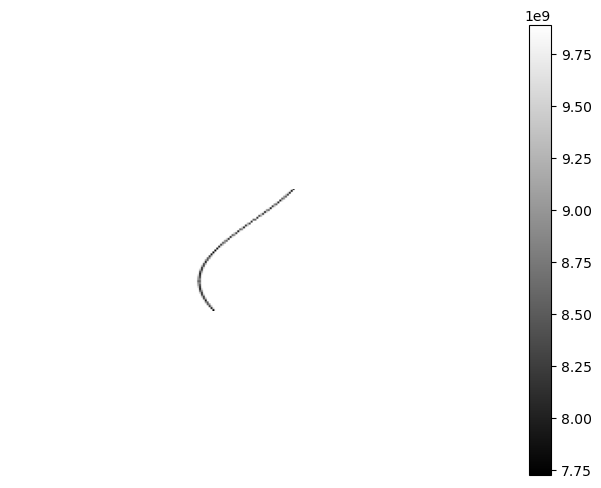

Scanning angle: 128   


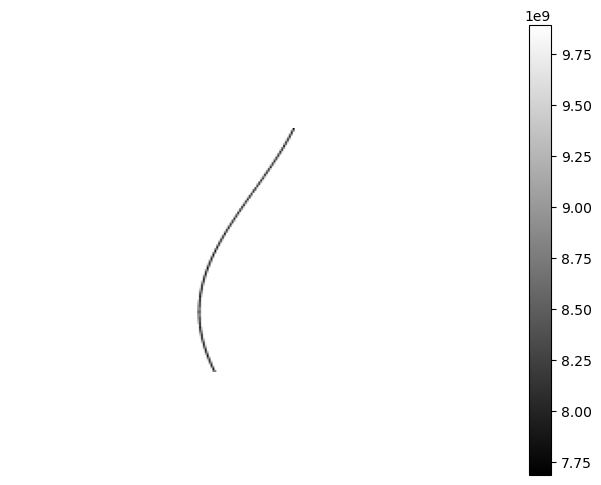

Scanning angle: 256   


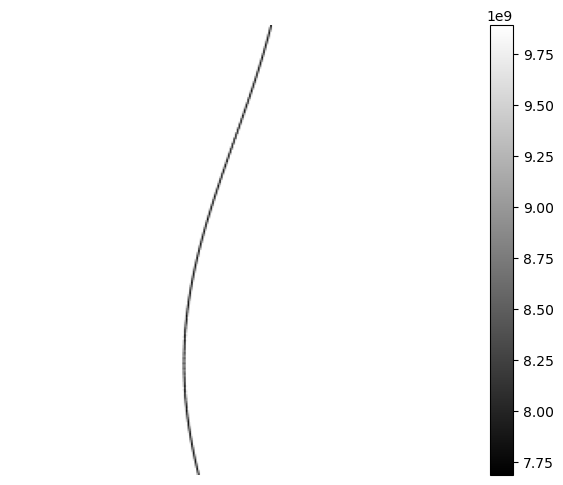

Scanning angle: 512   


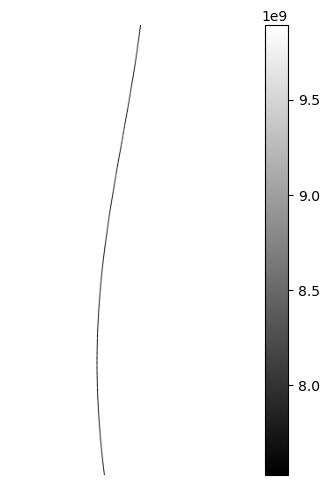

In [17]:
angles_ary = np.array([64, 128, 256, 512])
for angle in angles_ary:
    y2_offset = ct_scan(s_ideal, material, p2_offset, scale, angle)
    draw(y2_offset)


Scanning angle: 64   


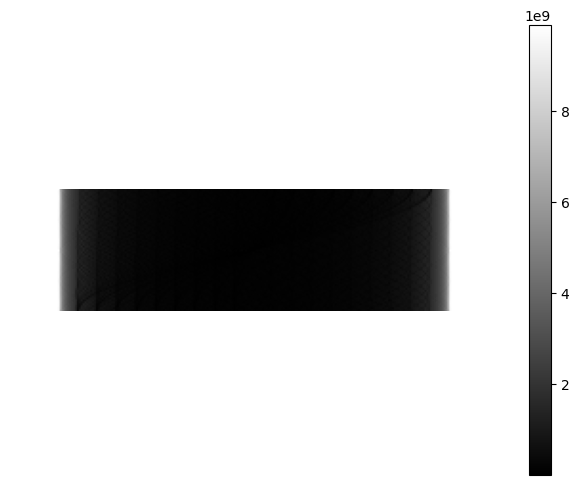

Scanning angle: 128   


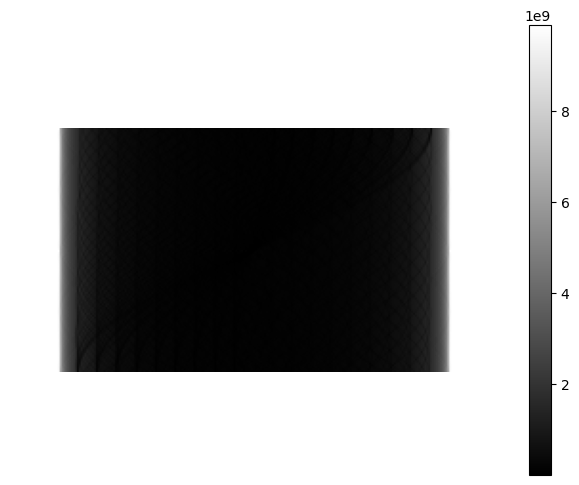

Scanning angle: 256   


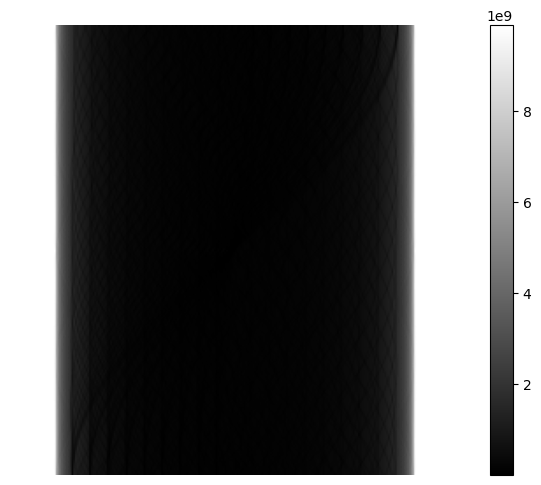

Scanning angle: 512   


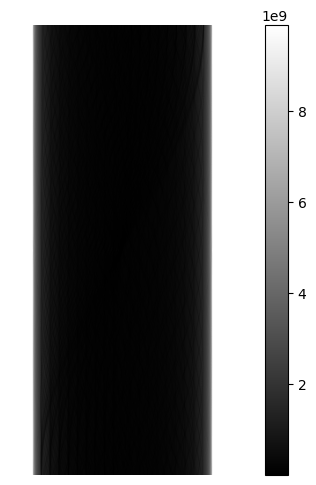

In [18]:
# Resolution phantom
p8 = ct_phantom(material.name, 256, 8, 'Titanium')
angles_ary = np.array([64, 128, 256, 512])
for angle in angles_ary:
    y8 = ct_scan(s_ideal, material, p8, scale, angle)
    draw(y8)

#### Investigate effect of interpolation technique.

In [ ]:
help(ndimage.map_coordinates)

mode : {'reflect', 'grid-mirror', 'constant', 'grid-constant', 'nearest', 'mirror', 'grid-wrap', 'wrap'}, optional
    The `mode` parameter determines how the input array is extended
    beyond its boundaries. Default is 'constant'. Behavior for each valid
    value is as follows (see additional plots and details on
    :ref:`boundary modes <ndimage-interpolation-modes>`):

    'reflect' (`d c b a | a b c d | d c b a`)
        The input is extended by reflecting about the edge of the last
        pixel. This mode is also sometimes referred to as half-sample
        symmetric.

    'grid-mirror'
        This is a synonym for 'reflect'.

    'constant' (`k k k k | a b c d | k k k k`)
        The input is extended by filling all values beyond the edge with
        the same constant value, defined by the `cval` parameter. No
        interpolation is performed beyond the edges of the input.

    'grid-constant' (`k k k k | a b c d | k k k k`)
        The input is extended by filling all values beyond the edge with
        the same constant value, defined by the `cval` parameter. Interpolation
        occurs for samples outside the input's extent  as well.

    'nearest' (`a a a a | a b c d | d d d d`)
        The input is extended by replicating the last pixel.

    'mirror' (`d c b | a b c d | c b a`)
        The input is extended by reflecting about the center of the last
        pixel. This mode is also sometimes referred to as whole-sample
        symmetric.

    'grid-wrap' (`a b c d | a b c d | a b c d`)
        The input is extended by wrapping around to the opposite edge.

    'wrap' (`d b c d | a b c d | b c a b`)
        The input is extended by wrapping around to the opposite edge, but in a
        way such that the last point and initial point exactly overlap. In this
        case it is not well defined which sample will be chosen at the point of
        overlap.
cval : scalar, optional
    Value to fill past edges of input if `mode` is 'constant'. Default
    is 0.0.

In [34]:
p1 = ct_phantom(material.name, 256, 1, 'Water')
y1_constant = ct_scan(s_ideal, material, p1, scale, angles)
y1_nearest = ct_scan(s_ideal, material, p1, scale, angles, mode = 'nearest')
y1_wrap = ct_scan(s_ideal, material, p1, scale, angles, mode = 'wrap')
y1_mirror = ct_scan(s_ideal, material, p1, scale, angles, mode = 'mirror')
y1_reflect = ct_scan(s_ideal, material, p1, scale, angles, mode = 'reflect')

Scanning angle: 256   
Scanning angle: 256   
Scanning angle: 256   
Scanning angle: 256   
Scanning angle: 256   


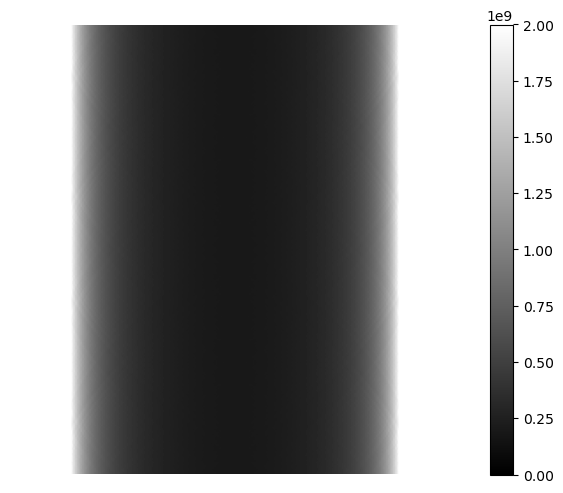

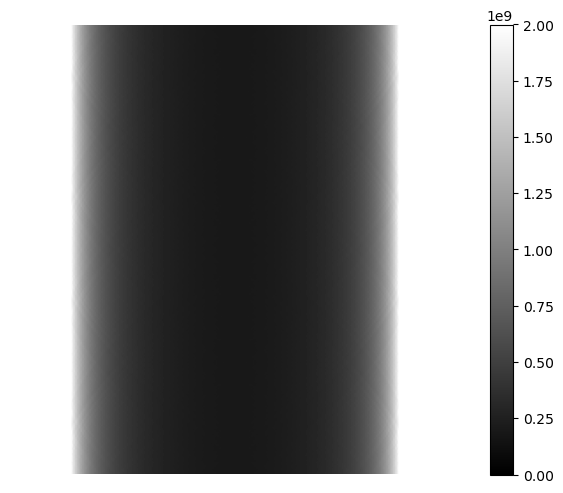

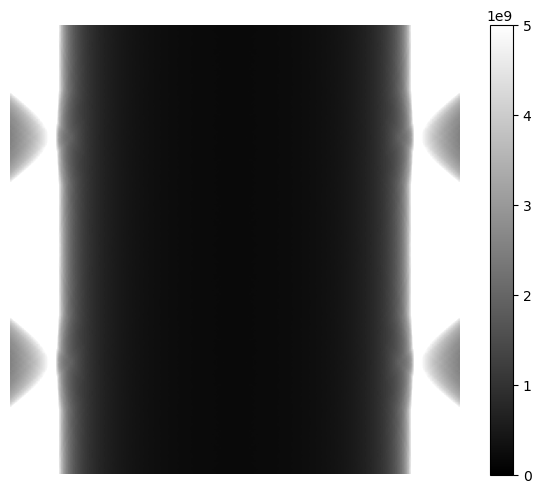

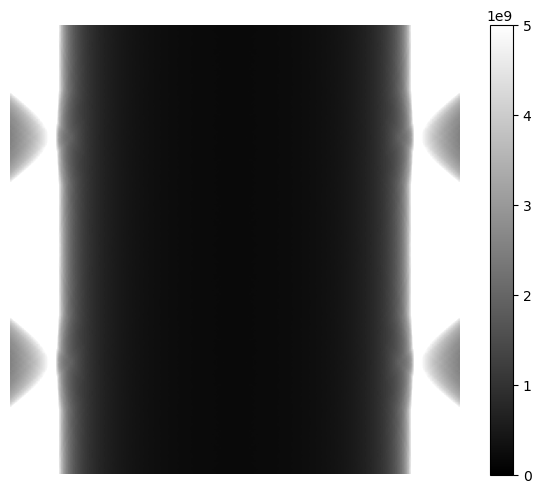

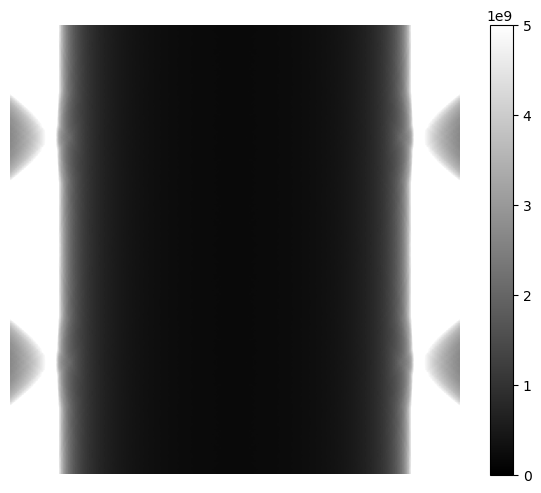

In [35]:
draw(y1_constant, caxis=[0, 2e9])
draw(y1_nearest, caxis=[0, 2e9])
draw(y1_wrap, caxis=[0, 5e9])
draw(y1_mirror, caxis=[0, 5e9])
draw(y1_reflect, caxis=[0, 5e9])

#### Investigate calibrated sinogram
Check that total attenutation p values scales with actual material attenuation

In [ ]:
# Extract the actual attenuation coefficient for all materials at 70 keV
energy_idx = np.nonzero(material.mev==0.07)[0][0]
mu_ary = material.coeffs[:,energy_idx]

p_ary = np.zeros(len(mu_ary))
for idx,mat_name in enumerate(material.name):
    p1_mat = ct_phantom(material.name, 256, 1, mat_name)
    y1_mat = ct_scan(s_ideal, material, p1_mat, scale, 64)
    y1_calibrate_mat = ct_calibrate(s_ideal, material, y1_mat, scale)
    p_ary[idx] = np.mean(y1_calibrate_mat[16:48, 112:144]) # Extract the centre patch of the sinogram and compute mean

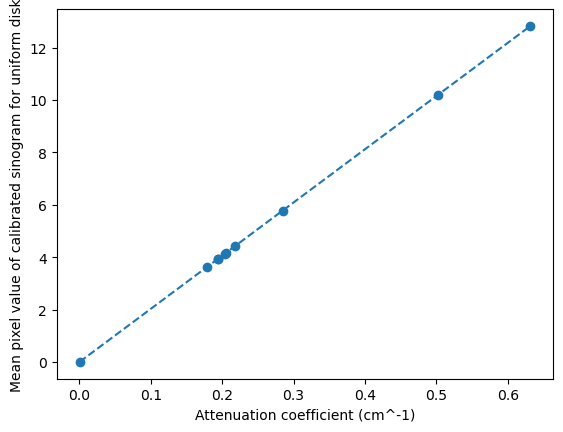

In [80]:
# Sort the data by attenuation coefficient
sorted_indices = np.argsort(mu_ary)
mu_sorted = mu_ary[sorted_indices]
p_sorted = p_ary[sorted_indices]

plt.figure()
plt.plot(mu_sorted[:10], p_sorted[:10], '--o')
# plt.xlim(0,0.8)
plt.xlabel('Attenuation coefficient (cm^-1)')
plt.ylabel('Mean pixel value of calibrated sinogram for uniform disk')
plt.show()